## Data Import

In [42]:
# import os, pandas as pd

# # Add asset from file system

# print(os.environ['DSX_PROJECT_DIR']+'/datasets/filename')

In [43]:
#Code to install imbalanced-learn. Credits: Ernest

# 1. Download imbalanced-learn from https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl 
# 2. Add it to the part where we add datasets

# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/imbalanced_learn-0.4.3-py3-none-any.whl'

# Install missingno
# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/missingno-0.4.1-py3-none-any.whl'

# Install mlxtend
# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/mlxtend-0.15.0.0-py2.py3-none-any.whl'

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import matplotlib.patches as mpatches # plot t-SNE, PCA, Truncated SVD
import missingno as msno

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs # feature selection

import seaborn as sns 

from imblearn.over_sampling import SMOTE

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.stats import norm
import numbers 

import pylab # t-SNE 
import time # t-SNE model
from sklearn.manifold import TSNE # t-SNE
from sklearn.decomposition import PCA, TruncatedSVD # PCA, SVD

In [3]:
# #Code to import dataset
# df = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/creditcard-training.csv')
# df.head()

In [20]:
df_raw = pd.read_csv('data/creditcard-training.csv')

# Data Exploration

In [21]:
#Get shape
df_raw.shape

(227844, 32)

In [22]:
#Print head
df_raw.head()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [23]:
#Rename the fraud column
df_raw = df_raw.rename( {'Fraud? (1: Fraud, 0:  No Fraud)' : 'Fraud'}, axis=1)
df_raw.head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [24]:
#Get NAs 
df_raw[df_raw.isnull().any(axis=1)].head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,22,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,23,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,33,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501


Text(0,0.5,'Frequency')

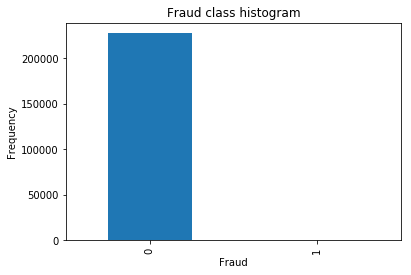

In [25]:
#EDA

#Checking the Target Classes
count_classes = pd.value_counts(df_raw['Fraud'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Fraud")
plt.ylabel("Frequency")

#The historgram shows that there is a need for resampling 


## Data Cleaning

In [26]:
#Summary of Missing Values and Range of Values Before Normalization
tab_info=pd.DataFrame(df_raw.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(df_raw.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.isnull().sum()/df_raw.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.min()).T.rename(index={0:'min value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.max()).T.rename(index={0:'max value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.max()-df_raw.min()).T.rename(index={0:'range (nb)'}))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tab_info)

                 Seconds since reference time   Amount  Fraud Feature 1  \
Column Type                             int64  float64  int64   float64   
null values (nb)                            0        0      0         0   
null values (%)                             0        0      0         0   
min value (nb)                              0        0      0  -4.49894   
max value (nb)                         145245  19656.5      1   5.82565   
range (nb)                             145245  19656.5      1   10.3246   

                 Feature 2 Feature 3 Feature 4  Feature 5  Feature 6  \
Column Type        float64   float64   float64    float64    float64   
null values (nb)         0         0         0         27         59   
null values (%)          0         0         0  0.0118502  0.0258949   
min value (nb)    -14.1299  -25.1628  -9.49875   -7.21353   -28.0096   
max value (nb)     8.28989   9.25353   5.04107    5.59197    39.4209   
range (nb)         22.4197   34.4163   14.

In [27]:
#Since the value of amount has a very different scale from the rest, we should condier normalising the column "amount"
#Method 1 Drop Seconds Since Reference Time Column
#Seconds since reference time column will be dropped as well since it has no significant contribution to the model building as it is simply a cheorogrphical order of the reference time
#df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#df = df.drop(['Seconds since reference time','Amount'],axis=1)
#df.head()

df = df_raw.copy()
#Method 2 Normalize Seconds Since Reference Time Column
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['normTime'] = StandardScaler().fit_transform(df['Seconds since reference time'].values.reshape(-1, 1))
df = df.drop(['Amount'],axis=1)
df.head()
df = df.drop(['Seconds since reference time'],axis=1)

#Deciding which method to choose depends on ?????


C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Outlier Removal

In [28]:
#Information on Column Types, No of Null Values, Min, Max 
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info=tab_info.append(pd.DataFrame(df.min()).T.rename(index={0:'min value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.max()).T.rename(index={0:'max value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.max()-df.min()).T.rename(index={0:'range (nb)'}))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tab_info)

                  Fraud Feature 1 Feature 2 Feature 3 Feature 4  Feature 5  \
Column Type       int64   float64   float64   float64   float64    float64   
null values (nb)      0         0         0         0         0         27   
null values (%)       0         0         0         0         0  0.0118502   
min value (nb)        0  -4.49894  -14.1299  -25.1628  -9.49875   -7.21353   
max value (nb)        1   5.82565   8.28989   9.25353   5.04107    5.59197   
range (nb)            1   10.3246   22.4197   34.4163   14.5398    12.8055   

                  Feature 6 Feature 7 Feature 8 Feature 9 Feature 10  \
Column Type         float64   float64   float64   float64    float64   
null values (nb)         59         0         0         0          0   
null values (%)   0.0258949         0         0         0          0   
min value (nb)     -28.0096  -34.8304  -10.9331  -44.8077   -2.83663   
max value (nb)      39.4209   27.2028   10.5031   19.0029    4.02287   
range (nb)          6

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


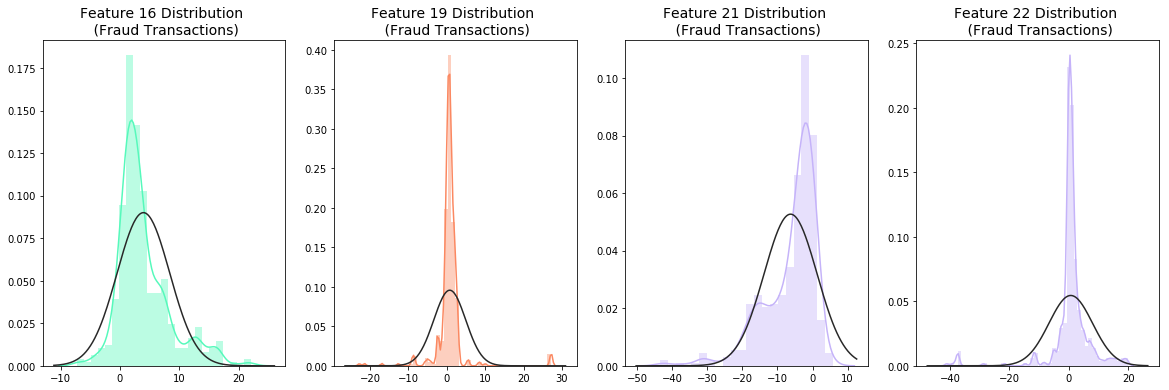

In [29]:
#Anomaly Detection 
#Plot Outliers in Boxplot and Remove Outliers 

from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v16_fraud_dist = df['Feature 16'].loc[df['Fraud'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax1, fit=norm, color='#56F9BB')
ax1.set_title('Feature 16 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = df['Feature 7'].loc[df['Fraud'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax2, fit=norm, color='#FB8861')
ax2.set_title('Feature 19 Distribution \n (Fraud Transactions)', fontsize=14)

v21_fraud_dist = df['Feature 21'].loc[df['Fraud'] == 1].values
sns.distplot(v21_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Feature 21 Distribution \n (Fraud Transactions)', fontsize=14)

v22_fraud_dist = df['Feature 22'].loc[df['Fraud'] == 1].values
sns.distplot(v22_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Feature 22 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

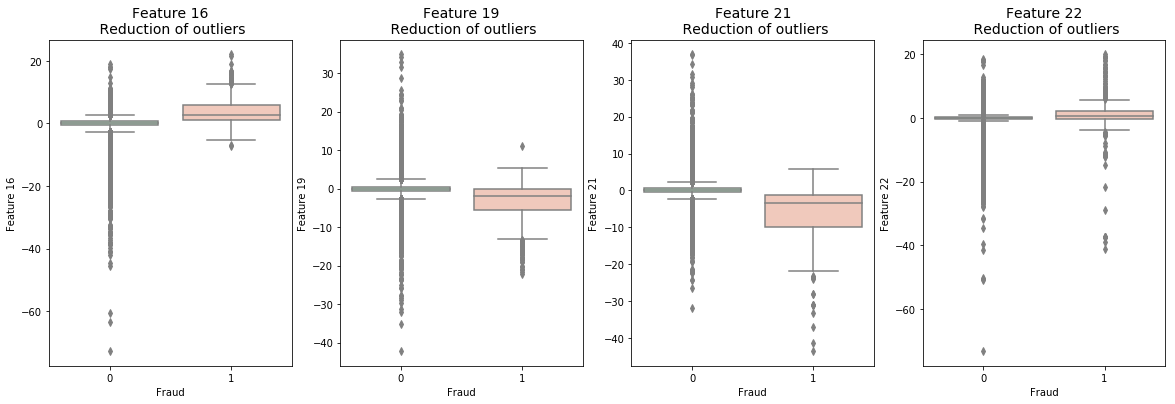

In [30]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplots with outliers removed
# Feature 16
sns.boxplot(x="Fraud", y="Feature 16", data=df,ax=ax1, palette=colors)
ax1.set_title("Feature 16\n Reduction of outliers", fontsize=14)

# Feature 19
sns.boxplot(x="Fraud", y="Feature 19", data=df, ax=ax2, palette=colors)
ax2.set_title("Feature 19\n Reduction of outliers", fontsize=14)

# Feature 21
sns.boxplot(x="Fraud", y="Feature 21", data=df, ax=ax3, palette=colors)
ax3.set_title("Feature 21\n Reduction of outliers", fontsize=14)

# Feature 22
sns.boxplot(x="Fraud", y="Feature 22", data=df, ax=ax4, palette=colors)
ax4.set_title("Feature 22\n Reduction of outliers", fontsize=14)


plt.show()

There are missing values so we will use Sklearn Imputer to impute

## Handle Missing Values

In [31]:
df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
0,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,...,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787,0.234706,-2.000787
1,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,...,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425,-0.351832,-2.000787
2,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,...,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654,1.149024,-2.000762
3,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,...,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024,0.130436,-2.000762
4,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,...,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739,-0.083174,-2.000737


In [32]:
#Print all missing values, if any
df[df.isnull().any(axis=1)].head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
10,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,0.313894,0.027740,...,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408,-0.331433,-2.000534
16,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,0.196002,0.013802,...,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333,-0.310715,-2.000484
25,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,-0.227404,0.742435,...,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664,-0.257063,-2.000231
28,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,0.457331,-0.038500,...,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392,-0.230836,-2.000205
42,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,0.258315,-0.264775,...,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501,-0.303490,-1.999952


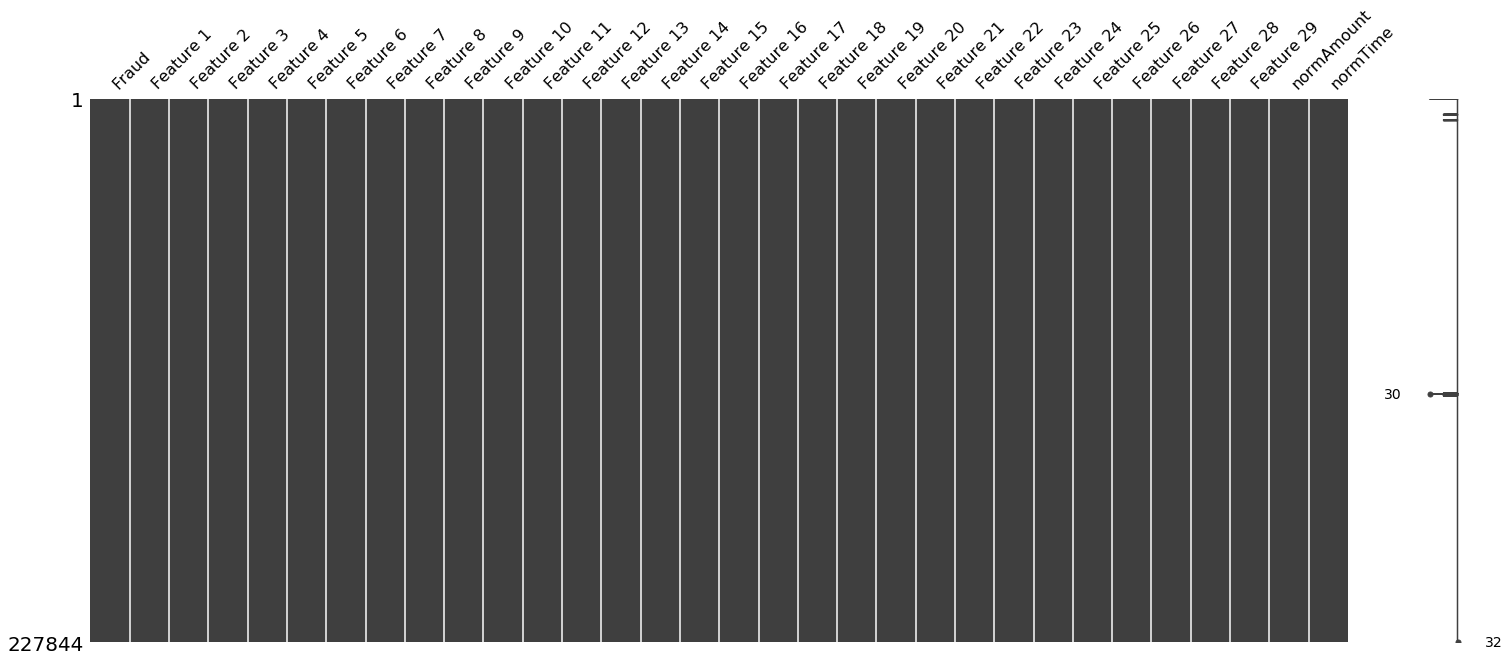

In [33]:
#Missing Values Pattern Analysis using missingno
msno.matrix(df)

Due to the drastic difference between the number of fraud cases and non-fraud cases, the missing values analysis is not really appropriate in this dataset.

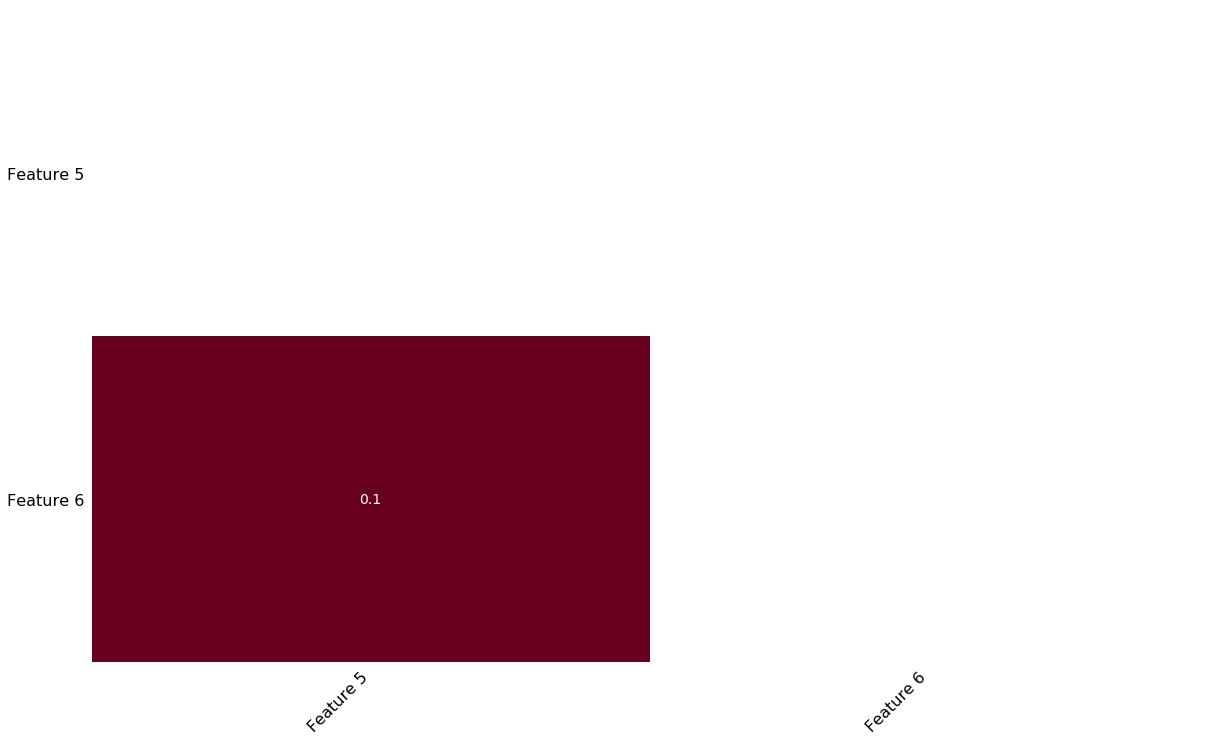

In [34]:
#Visualise the Correleation Matrix about the locations of missing values in columns 
msno.heatmap(df)


The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another. In this case, it shows that only Feature 6 and 5 are missing and there is a 0.1 correlation between the missing values in these two columns.

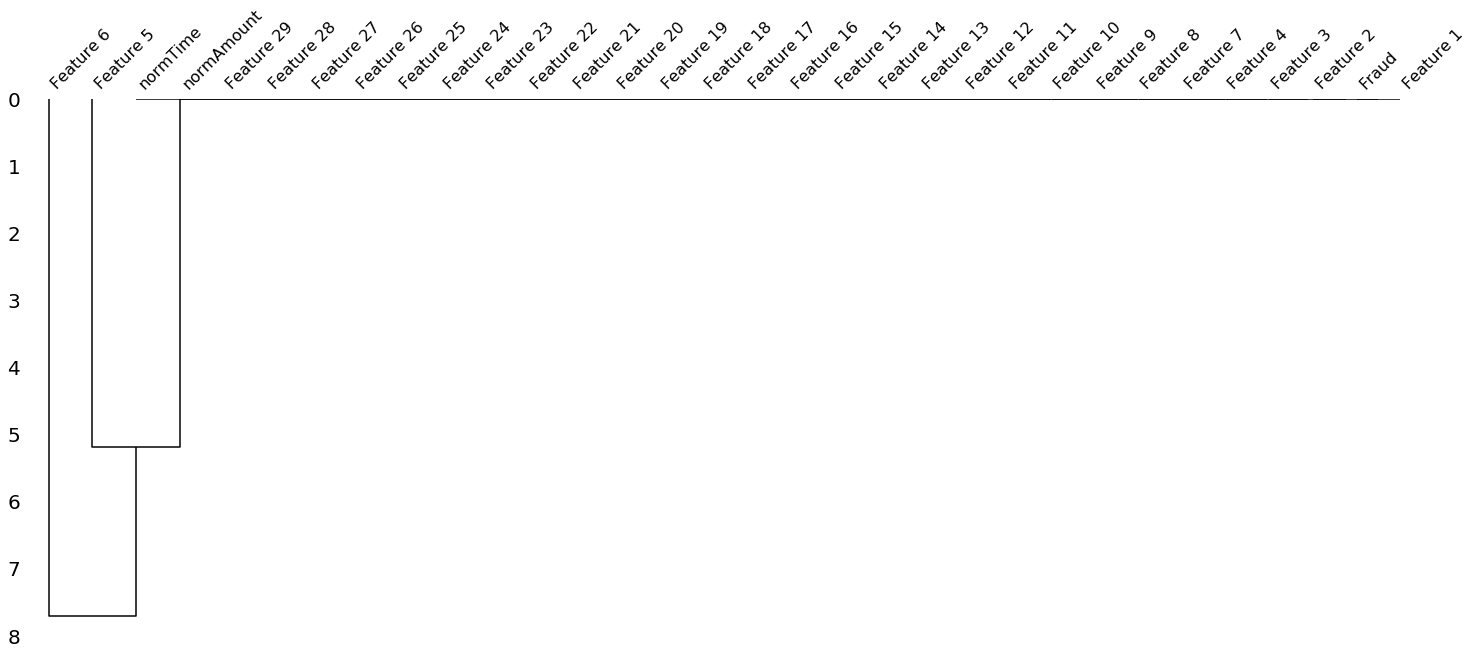

In [35]:
msno.dendrogram(df)

Interpreting Dendrogram:

The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity (for example, as CONTRIBUTING FACTOR VEHICLE 2 and VEHICLE TYPE CODE 2 ought to), then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined.

Analysis:

There is a relationship between normAmount and the missing values for Feature 5
There is also a relationship between missing values for Feature 5 and Feature 6
Missing Values Type Analysis To better able to understand the missing values pattern, we should distinguish whether the missing values are missing completely at random (MCAR), missing at random (MAR) or missing not at random (MNAR). In this case, we can notice that the missing values are definitely NOT missing completely at random since there is an association between the missing values and the observed variabels. However, as the features details are not known (only know Feature 1, 2, 3 etc), we cannot distinguish whether the missing values are Missing at Random (MAR) or Missing Not at Random (MNAR). We will continue to use multiple imputation to fill in the missing values as this is the most appropriate method

In [36]:
#Use sklearn Impute to impute missing values
features = df.values
imp = SimpleImputer(missing_values = np.nan, strategy='mean')

#Only feature 5 and feature 6 have NaN
features[:,[5,6]] = imp.fit_transform(features[:,[5,6]])

df1 = pd.DataFrame(features)
df1.columns = df.columns
df = df1
df[df.isnull().any(axis=1)]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


In [37]:
#Get difference in means between Fraud and not-fraud
df.groupby('Fraud').mean()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
Fraud,,,,,,,,,,,,,,,,,,,,,
0.0,0.049387,0.002841,0.028799,-0.018164,-0.008677,0.009279,-0.007071,-0.022976,-0.009824,0.001263,...,0.002776,0.026436,0.045807,0.016831,-0.032826,0.068994,0.009538,0.007167,-0.000255,0.000545
1.0,-0.098209,-4.559229,-7.423533,-2.589217,0.761240,0.371774,0.765659,0.013088,-0.060036,-0.083433,...,0.663762,0.613894,-7.024019,-0.048627,-6.685076,4.046820,-6.135121,-2.696376,0.139044,-0.297025


In [38]:
#Get number of fraud and not fraud values
fraud_rows = df['Fraud'].value_counts()
total_rows = df.shape[0]
percentage_fraud = fraud_rows[1]/total_rows

print("Fraud rows: ", fraud_rows[1])
print("Total rows: ", total_rows)
print("Percentage rows: ", percentage_fraud)

Fraud rows:  417
Total rows:  227844
Percentage rows:  0.0018301996102596514


## Check for Duplicates

In [39]:
#Get all duplicates, if any
df[df.duplicated()==True]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


There are no duplicates. So we can move on.

# Feature Selection

In [40]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 417 rows.
fraud_df = df.loc[df['Fraud'] == 1]
non_fraud_df = df.loc[df['Fraud'] == 0][:417]

#Equal number of fraud and non fraud
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
140987,0.0,1.022696,-0.227947,-0.228134,-0.035865,0.448789,0.012422,0.077499,0.311384,-0.095417,...,-0.003885,2.901838,0.138062,1.185735,0.539832,-0.351497,-0.194192,-0.741823,-0.359457,0.127209
199305,0.0,-3.223759,0.363562,0.151399,0.219379,-0.382948,1.428855,-3.991062,0.558914,0.508761,...,-7.008012,-14.413251,1.650999,-2.714224,0.885482,-1.090292,-2.503960,-0.694888,-0.314667,1.363284
214775,1.0,-0.775503,-0.911031,-0.223768,0.768370,0.477521,-1.027716,1.377515,2.151787,0.189225,...,-0.992260,13.598264,1.065262,-2.215525,-0.075707,0.253931,0.217630,0.756307,-0.359816,1.538348
23843,0.0,-0.363776,-0.357369,0.113228,0.372694,-0.759947,0.217286,0.085652,0.288131,0.082866,...,-0.092337,12.985083,-0.351268,0.106658,-0.797578,0.960891,0.912492,-2.653680,0.340014,-1.166806
15225,1.0,0.000947,-6.947746,-13.472897,-4.940211,1.230143,1.582930,1.750730,-1.409636,-0.809809,...,13.276805,14.231581,-8.578973,0.230825,-8.088034,5.730816,-8.859194,-3.974162,0.036585,-1.327847


### Correlation Matrix

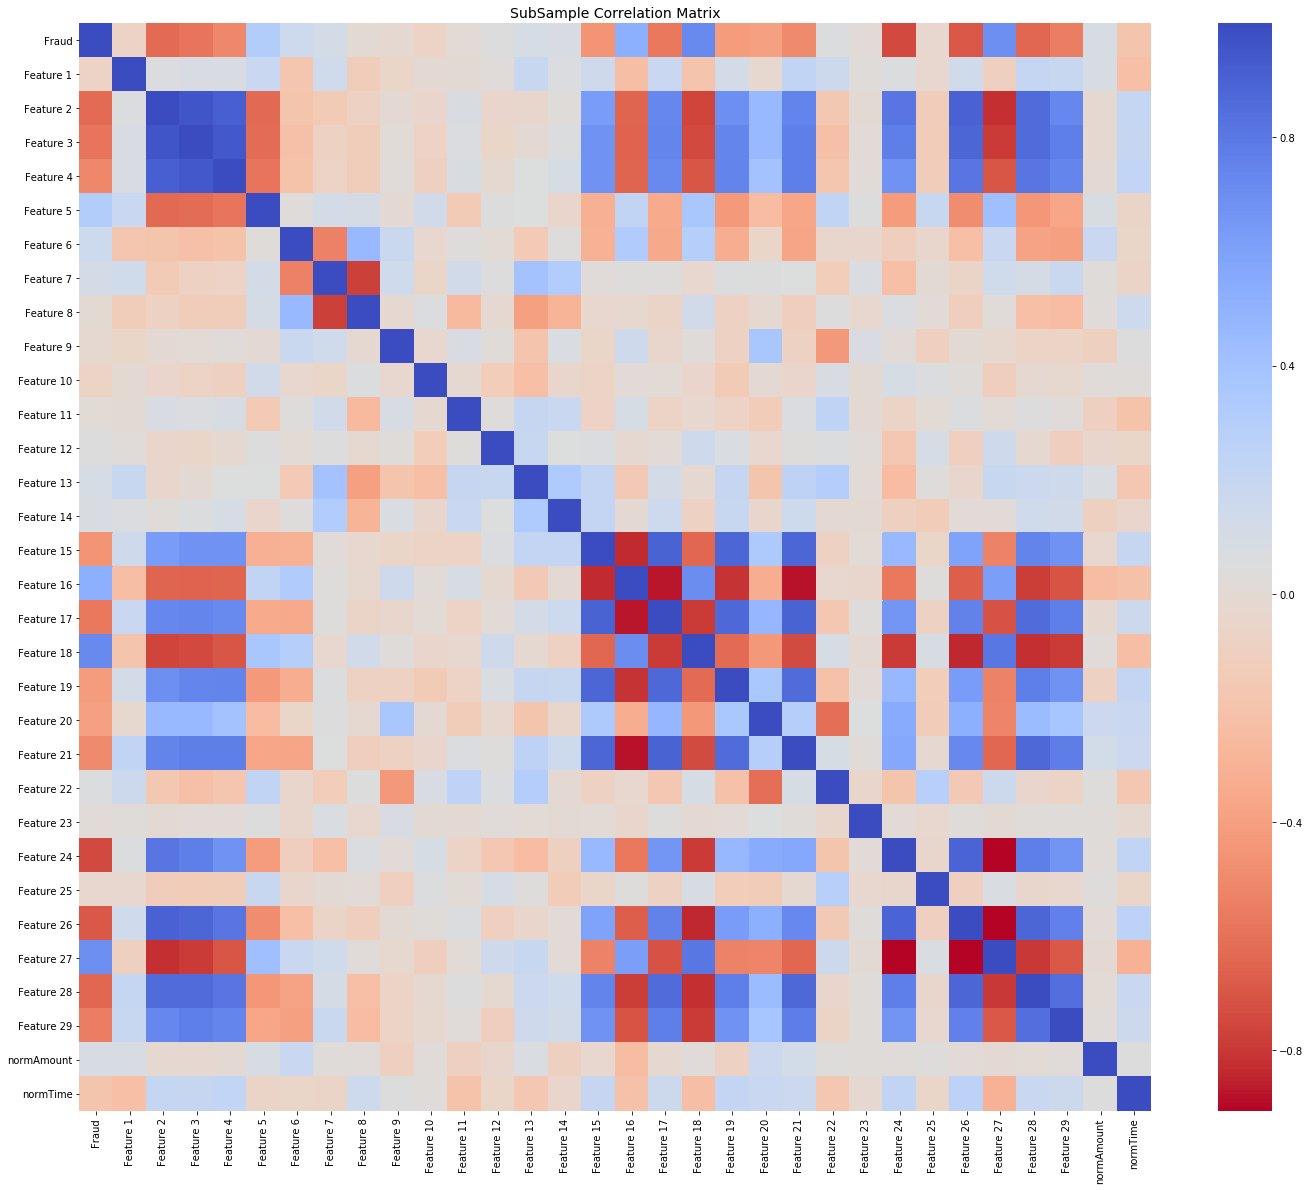

In [41]:
# Shuffle dataframe rows
df_sample = normal_distributed_df.sample(frac=1, random_state=42)

f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = df_sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

<b>Negative Correlations</b>: Features (7 and 8), (15 and 16), (16 and 17), (16 and 21), (24 and 27), (26 and 27) are negatively correlated. <br/>
<b>Positive Correlations</b>:Features (2,3, and 4), (2 and 26), (15 and 21) are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

So now we will be removing features 7, 16, 27, 2, 21

In [42]:
normal_distributed_df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)
df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)

## Random Forest 

In [76]:
#Small contains equal number of fraud and non-fraud rows
y_small = normal_distributed_df['Fraud']
X_small = normal_distributed_df.drop('Fraud', axis=1)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, train_size=0.8, random_state=0)

#This contains the actual train and test data
y = df['Fraud']
X = df.drop('Fraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [73]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
#After a lot of trial-error, features=17 has been selected.
#We have not shown all in the notebook in the interest of time of execution.
sfs1 = sfs(clf,
           k_features=17,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

# Perform SFFS
sfs1 = sfs1.fit(X_train_small, y_train_small)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   27.7s finished

[2019-03-17 08:54:43] Features: 1/17 -- score: 0.8906042884990253[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   26.7s finished

[2019-03-17 08:55:10] Features: 2/17 -- score: 0.922027290448343[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   26.1s finished

[2019-03-17 08:55:36] Features: 3/17 -- score: 0.925079365079365[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

In [ ]:
# Get the features that were selected as predictors
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

In [ ]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train.iloc[:, feat_cols], y_train)

y_train_pred = clf.predict(X_train.iloc[:, feat_cols])
print('Training accuracy on selected features: %.3f' % accuracy_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test.iloc[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % accuracy_score(y_test, y_test_pred))

In [ ]:
# Build full model without selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Training accuracy on selected features: %.3f' % accuracy_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print('Testing accuracy on selected features: %.3f' % accuracy_score(y_test, y_test_pred))

Therefore, we will be moving forward with these features only

In [44]:
#Keep only the columns that are important
feat_cols = [0, 1, 3, 4, 5, 6, 7, 10, 11, 13, 15, 17, 19, 20, 21]
X_train = X_train.iloc[:, feat_cols]
X_test = X_test.iloc[:, feat_cols]

## T-SNE

In [ ]:
# New_df is from the random undersample data (fewer instances)
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

X = new_df.drop('Fraud', axis=1)
y = new_df['Fraud']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(8,8))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

plt.show()

# Data Resampling

In [45]:
#Function to plot data. Will be used later
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [46]:
#Use SMOTE to resample
method = SMOTE(kind='regular')

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

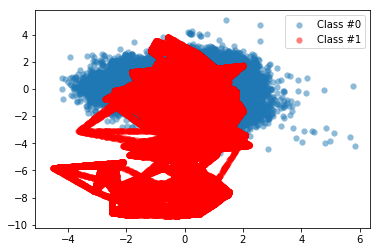

numpy.ndarray

In [47]:
plot_data(X_resampled, y_resampled)
type(X_resampled)

In [48]:
print("Before resampling")
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print("After resampling")
print(pd.value_counts(pd.Series(y_resampled)))

Before resampling
0.0    227427
1.0       417
Name: Fraud, dtype: int64
After resampling
1.0    181965
0.0    181965
dtype: int64


# Supervised Learning Models

## Logistic Regression

In [53]:
# Continue fitting the model and obtain predictions
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Get your performance metrics
predicted = model_lr.predict(X_test)

# Predict probabilities
probs = model_lr.predict_proba(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('AUC Score: ',roc_auc_score(y_test, probs[:,1]))
print("F SCORE", f1_score(y_test, predicted))

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45462
         1.0       0.89      0.68      0.77       107

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.94      0.84      0.89     45569
weighted avg       1.00      1.00      1.00     45569

Confusion matrix:
 [[45453     9]
 [   34    73]]
AUC Score:  0.9578325042543491
F SCORE 0.7724867724867724


## Use Decision Tree 

In [54]:
model_dt = DecisionTreeClassifier(random_state=5)

# Fit the model to our resampled dataset
model_dt.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_dt.predict(X_test)

# Print the accuracy performance metric
# print(accuracy_score(y_test, predicted))

# Predict probabilities
probs = model_dt.predict_proba(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print("F SCORE", f1_score(y_test, predicted))
print('AUC Score: ',roc_auc_score(y_test, probs[:,1]))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45462
         1.0       0.43      0.86      0.57       107

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.71      0.93      0.78     45569
weighted avg       1.00      1.00      1.00     45569

Confusion matrix:
 [[45338   124]
 [   15    92]]
F SCORE 0.5696594427244582
AUC Score:  0.9285427657153947


### Random Forest

### Parameter tuning for Random Forest

Get number of estimators

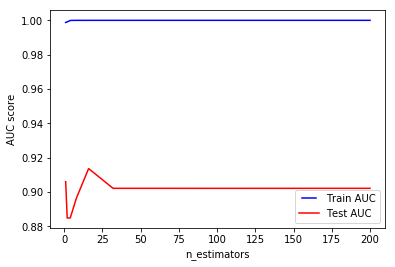

In [95]:
# n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
# train_results = []
# test_results = []
# for estimator in n_estimators:
#     rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
#     rf.fit(X_resampled, y_resampled)
#     train_pred = rf.predict(X_resampled)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_resampled, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
#     y_pred = rf.predict(X_test)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     test_results.append(roc_auc)
    
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
# line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('n_estimators')
# plt.show()

Therefore, we can see that once we cross 24, there's no increase in AUC if we increase the number of estimators. 

Get max Depth

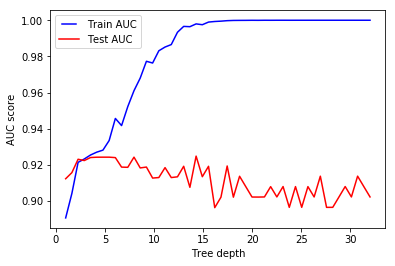

In [99]:
# max_depths = np.linspace(1, 32, endpoint=True)
# train_results = []
# test_results = []
# for max_depth in max_depths:
#     rf = RandomForestClassifier(n_estimators=24, max_depth=max_depth, n_jobs=-1)
#     rf.fit(X_resampled, y_resampled)
#     train_pred = rf.predict(X_resampled)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_resampled, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
#     y_pred = rf.predict(X_test)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     test_results.append(roc_auc)
    
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
# line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('Tree depth')
# plt.show()

Thus, we will select max depth of 5

Random Forest before resampling:

In [55]:
model_rf = RandomForestClassifier(n_estimators = 24,random_state=5)

# Fit the model to our resampled dataset
model_rf.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model_rf.predict(X_test)

# Print the accuracy performance metric
# print(accuracy_score(y_test, predicted))

# Predict probabilities
probs = model_rf.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print("AUC Score: ",roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F SCORE", f1_score(y_test, predicted))

0.9434520028434962
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45462
         1.0       0.96      0.80      0.87       107

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.98      0.90      0.94     45569
weighted avg       1.00      1.00      1.00     45569

[[45458     4]
 [   21    86]]
F SCORE 0.8730964467005076


In [107]:
model_rf = RandomForestClassifier(n_estimators = 24, max_depth=3, random_state=5)

# Fit the model to our resampled dataset
model_rf.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model_rf.predict(X_test)

# Print the accuracy performance metric
# print(accuracy_score(y_test, predicted))

# Predict probabilities
probs = model_rf.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F SCORE", f1_score(y_test, predicted))

0.9468714919177322
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45482
         1.0       0.81      0.60      0.69        87

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.91      0.80      0.84     45569
weighted avg       1.00      1.00      1.00     45569

[[45470    12]
 [   35    52]]
F SCORE 0.6887417218543046


Random Forest after resampling

In [109]:
# Define the model as the random forest
model_rf_re = RandomForestClassifier(n_estimators=24,random_state=5)

# Fit the model to our resampled dataset
model_rf_re.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_rf_re.predict(X_test)

# Predict probabilities
probs = model_rf_re.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F SCORE", f1_score(y_test, predicted))
print("AUC Score: ",roc_auc_score(y_test, probs[:,1]))

0.9495371921796018
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45482
         1.0       0.89      0.80      0.84        87

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.94      0.90      0.92     45569
weighted avg       1.00      1.00      1.00     45569

[[45473     9]
 [   17    70]]
F SCORE 0.8433734939759037


In [1]:
# Without parameter tuning
model_rf_re = RandomForestClassifier(random_state=5)

# Fit the model to our resampled dataset
model_rf_re.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_rf_re.predict(X_test)

# Predict probabilities
probs = model_rf_re.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F1 SCORE", f1_score(y_test, predicted))

NameError: name 'RandomForestClassifier' is not defined

<div class="alert alert-success">
    Out of all the models employed, we will be using this one as it provides the best F score
</div>

## Plot learning curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title= "Learning Curve"
plot_learning_curve(model_rf, title, X_train, y_train)

plt.show()

From the learning curve, we can see that the bias-variance trade-off is not very bad and we'll continue with this model

## Cross Validation

In [81]:
from sklearn.model_selection import KFold 
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 


model_rf_re = RandomForestClassifier(random_state=5)

for train_index, test_index in kf.split(X):
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit the model to our resampled dataset
    model_rf_re.fit(X_train, y_train)

    # Obtain predictions from the test data 
    predicted = model_rf_re.predict(X_test)

    # Predict probabilities
    probs = model_rf_re.predict_proba(X_test)

    # Print the ROC curve, classification report and confusion matrix
    print("AUC: ",roc_auc_score(y_test, probs[:,1]))
#     print(classification_report(y_test, predicted))
    print("Confusion: ",confusion_matrix(y_test, predicted))

Train: [     0      2      4 ... 227841 227842 227843] Validation: [     1      3     35 ... 227835 227836 227838]


C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9006489794123376
[[45475     3]
 [   24    67]]
Train: [     0      1      2 ... 227840 227841 227842] Validation: [     6      8      9 ... 227816 227818 227843]
0.9330011283539221
[[45491     3]
 [   16    59]]
Train: [     0      1      3 ... 227840 227842 227843] Validation: [     2      4      5 ... 227833 227834 227841]
0.9272208737723674
[[45489     4]
 [   18    58]]
Train: [     1      2      3 ... 227840 227841 227843] Validation: [     0      7     14 ... 227823 227837 227842]
0.921168315567809
[[45460     7]
 [   29    73]]
Train: [     0      1      2 ... 227841 227842 227843] Validation: [    10     12     16 ... 227832 227839 227840]
0.9379880673324028
[[45493     2]
 [   24    49]]
Train: [     1      2      3 ... 227839 227841 227843] Validation: [     0      5     14 ... 227834 227840 227842]
0.94548130525002
[[45483     3]
 [   16    67]]
Train: [     0      1      2 ... 227841 227842 227843] Validation: [     4      6      8 ... 227802 227812 227833]
0.95432906142

In [ ]:
Cross validation is used to evaluate the auc score of the models.